In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from pandas.api.types import CategoricalDtype

from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import matplotlib.dates as mdates

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import patsy

from lifelines import KaplanMeierFitter

import dataStatsAnalysis as dsa
import dataStatsPlotting as dsp

dsp.SetParams()

### Means function

In [2]:
def ResampleMean(data, weights=None, iters=100):
    """Uses sampling with replacement to generate a sampling distribution of mean for a variable.
    Can then make an rv of the distributions to plot cdf, compute p-value of hypothesized mean (eg. rv.cdf at 0), 
    and calculate sample distribution mean, std deviation (std error), and confidence interval (rv.interval).

    Args:
        data (array-like): Data for the variable of interest
        weights (array-like, optional): Can include weights for the data. Used as DataFrame.sample parameter. Defaults to None.
        iters (int, optional): The number of resampling iterations. Defaults to 100.

    Returns:
        mean_estimates (array): A mean estimates sampling distribution
    """
    # Resample with replacement, calculating the mean of the data and building a list of mean estimates
    if weights is None:   # In case of no weights, use a Series
        s = pd.Series(data)
        mean_estimates = [s.sample(n=len(s), replace=True).mean() for _ in range(iters)]
    
    else:    # In case of weights use a DataFrame
        df = pd.DataFrame({'data':data,'wgt':weights})
        mean_estimates = [df.sample(n=len(df), replace=True, weights=df.wgt).data.mean() for _ in range(iters)]
    
    return np.array(mean_estimates)

In [3]:
# Add: return an rv as well
# Note that this function can be used to make sample distributions for binary data too
def ResampleMean_new(data, weights=None, iters=1000):
    """Uses sampling with replacement to generate a sampling distribution of mean for a variable.
    Can then make an rv of the distributions to plot cdf, compute p-value of hypothesized mean (eg. rv.cdf at 0), 
    and calculate sample distribution mean, std deviation (std error), and confidence interval (rv.interval).

    Args:
        data (array-like): Data for the variable of interest
        weights (array-like, optional): Can include weights for the data. Used as DataFrame.sample parameter. Defaults to None.
        iters (int, optional): The number of resampling iterations. Defaults to 1000.

    Returns:
        mean_estimates (array): A mean estimates sampling distribution
    """
    # Resample with replacement, calculating the mean of the data and building a list of mean estimates
    if weights is None:   # In case of no weights, use a Series
        s = pd.Series(data)
        mean_estimates = [s.sample(n=len(s), replace=True).mean() for _ in range(iters)]
    
    else:    # In case of weights use a DataFrame
        df = pd.DataFrame({'data':data,'wgt':weights})
        mean_estimates = [df.sample(n=len(df), replace=True, weights=df.wgt).data.mean() for _ in range(iters)]
    
    return np.array(mean_estimates)

### Try getting a two-tailed p value using a resampled mean

In [4]:
data = np.random.randint(-10,13,size=100)

In [5]:
dist = ResampleMean_new(data)
rv = dsa.DiscreteRv(dist)

In [6]:
# p-value at 0
rv.cdf(0)

0.006

In [7]:
# The two-tailed p value using the scipy stats function is about double what I get from above
stats.ttest_1samp(data,0)

Ttest_1sampResult(statistic=2.544226358821578, pvalue=0.012497821441806108)

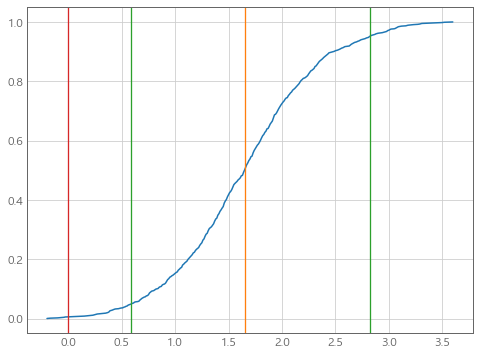

In [8]:
# Check if the rv sampling distribution is symmetrical by plotting and looking at the tails

fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(rv.xk, rv.cdf(rv.xk))
ax.axvline(rv.mean(), color='C1', lw=1.3) # mean, orange line
ax.axvline(rv.ppf(.05), color='C2', lw=1.3) # CI lower, green line
ax.axvline(rv.ppf(.95), color='C2', lw=1.3) # CI upper, green line
ax.axvline(0, color='C3', lw=1.3) # p-value (if comparing with zero), red line

In [9]:
rv.ppf(1-rv.cdf(0))

3.31

In [10]:
1-rv.cdf(rv.ppf(1-rv.cdf(0)))

0.004999999999999227

In [11]:
# Two-tailed p-value by adding the tails
rv.cdf(0) + 1-rv.cdf(rv.ppf(1-rv.cdf(0)))

0.010999999999999233

In [12]:
# Two-tailed p-value by adding on the probability that is equidistant from the mean as the mean is from zero
rv.cdf(0) + 1-rv.cdf(rv.mean()*2)

0.010999999999999233

In [13]:
# Two-tailed p-value using median
rv.cdf(0) + 1-rv.cdf(rv.median()*2)

0.012999999999999234

In [14]:
# Two-tailed p-value just by doubling one-tailed
rv.cdf(0)*2

0.012

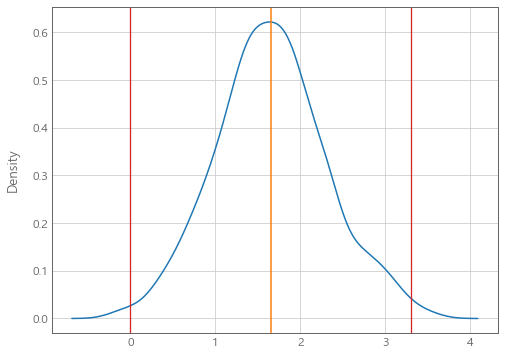

In [15]:
# Look at kde too

fig,ax = plt.subplots()
fig.set_size_inches(8,6)

sns.kdeplot(dist, ax=ax)
plt.axvline(rv.mean(), color='C1', lw=1.5)

# ax.plot(rv.xk, rv.cdf(rv.xk))
# ax.plot([rv.median(), rv.median()], [0, 1], color='C2')
# ax.plot([rv.ppf(.05), rv.ppf(.05)], [0, 1], color='0.8')
# ax.plot([rv.ppf(.95), rv.ppf(.95)], [0, 1], color='0.8')
plt.axvline(0, color='C3', lw=1.3) # lower p-value, red line
plt.axvline(rv.ppf(1-rv.cdf(0)), color='C3', lw=1.3) # upper p-value, red line

In [16]:
1-rv.cdf(rv.median()*2)

0.006999999999999229

In [17]:
rv.mean(), rv.median()

(1.65799, 1.65)

In [18]:
# This below is a test of using my resampling function versus the Wilcoxon one-sample test
# The example came from here:
# https://learn.lboro.ac.uk/archive/olmp/olmp_resources/pages/workbooks_1_50_jan2008/Workbook45/45_1_non_pmtrc_tsts_sngl_smpl.pdf
s = pd.Series([2128.7, 1679.1, 2317.2, 2001.3, 2107.6, 1718.4, 1787.4, 2562.3, 2356.9, 2153.2, 2167.1, 2387.5, 1679.9,
                       2323.2, 1788.4, 2153.6, 2423.3, 2122.6, 2644.3, 1737.4])

In [19]:
s_dist = dsa.ResampleMean(s,iters=1000)

In [20]:
# My result is very close to the one from the example (0.05766)
# Interestingly in the example they state that since this is a two-tailed test we must compare the obtained value to 0.025
# This is an interesting way to look at significance in a two-tailed test when you have just a one-sided p-value
dsa.PvalueFromEstimates(s_dist, 2000, tail='left')

0.03300000000000002

In [21]:
# This gives the two-sided p-value
stats.wilcoxon(s-2000)

WilcoxonResult(statistic=65.0, pvalue=0.13535690010210896)

### Difference in means

In [22]:
import first

live, firsts, others = first.MakeFrames()

In [23]:
# Test new alternative hypothesis diff means function pvalue against pvalue from null hypothesis diff means function

In [24]:
diff_means_results_H0 = dsa.ResampleDiffMeans_H0(firsts.prglngth, others.prglngth)
diff_means_results_H0[0]

0.07803726677754952

In [25]:
diff_means_results_Ha = dsa.ResampleDiffMeans_Ha(firsts.prglngth, others.prglngth)

In [26]:
# Null hypothesis pvalue
diff_means_rv_H0 = dsa.DiscreteRv(diff_means_results_H0[1])

1-diff_means_rv_H0.cdf(diff_means_results_H0[0])

0.16699999999999937

In [27]:
# Alternative hypothesis pvalue
# This is half the null hypothesis value which what we would expect because the H0 function is set to two-sided
diff_means_rv_Ha = dsa.DiscreteRv(diff_means_results_Ha[1])

diff_means_rv_Ha.cdf(0)

0.07400000000000005

### Create a new correlation Ha function

In [28]:
def ResampleCorrelation_H0(x, y, iters=1000, onesided=False, method='pearson'):
    """Generates a correlation sampling distribution for the null hypothesis of no correlation between the variables via permutation of one of the variables. 
    Can then make an rv of this distribution to plot cdf, compute p-value for the actual correlation value (eg. rv.cdf at actual correlation(test_r)). 
    Can also use the 'min' and 'max' built-ins to find what the most extreme values are from the simluations.

    Args:
        x (array-like): Input variable 1
        y (array-like): Input variable 2
        iters (int): The number of simulations to run (Defaults to 1000)
        onesided (bool): If set to True a onesided test, that does not use absolute value of difference, is run (Defaults to False)
        method (string): Select 'pearson' or 'spearman' method (default: 'pearson')

    Returns:
        test_r: Original actual correlation value
        corrs (array): Sampling distribution for the null hypothesis of no correlation obtained from resampling
    """
    xs, ys = np.array(x), np.array(y)
    
    if method == 'pearson':

        corrs=[]    
        if onesided == False:
            test_r = abs(stats.pearsonr(xs, ys)[0])

            for _ in range(iters):
                xs = np.random.permutation(xs)
                corr = abs(stats.pearsonr(xs, ys)[0])
                corrs.append(corr)

        elif onesided == True:
            test_r = stats.pearsonr(xs, ys)[0]

            for _ in range(iters):
                xs = np.random.permutation(xs)
                corr = stats.pearsonr(xs, ys)[0]
                corrs.append(corr)

        else:
            raise TypeError('\'onesided\' parameter only accepts Boolean True or False')
    
    elif method == 'spearman':

        corrs=[]    
        if onesided == False:
            test_r = abs(stats.spearmanr(xs, ys)[0])

            for _ in range(iters):
                xs = np.random.permutation(xs)
                corr = abs(stats.spearmanr(xs, ys)[0])
                corrs.append(corr)

        elif onesided == True:
            test_r = stats.spearmanr(xs, ys)[0]

            for _ in range(iters):
                xs = np.random.permutation(xs)
                corr = stats.spearmanr(xs, ys)[0]
                corrs.append(corr)

        else:
            raise TypeError('\'onesided\' parameter only accepts Boolean True or False')        
    
    else:
        raise Exception('Must enter either pearson or spearman as a string for method argument')       
    
    return test_r, np.array(corrs)


In [29]:
def ResampleCorrelation_Ha(x, y, iters=1000, method='pearson'):
    """Generates a correlation sampling distribution for the alternative hypothesis of correlation existing between the variables. 
    This is done by resampling x, y pairs and calculating correlation on new samples. 
    Can then make an rv of this distribution to calculate sampling distribution mean, std deviation (std error), and confidence interval (rv.interval). 
    Can also get a one-sided p-value for case of no difference null hypothesis using rv.cdf(0). 
    For two-sided p-value, can double the one-sided if sampling distribution is symmetrical or use the H0 version of this function. 
    Can also use the 'min' and 'max' built-ins to find what the most extreme values are from the simluations.

    Args:
        x (array-like): Input variable 1
        y (array-like): Input variable 2
        iters (int): The number of simulations to run (Defaults to 1000)
        method (string): Select 'pearson' or 'spearman' method (default: 'pearson')
        
    Returns:
        actual_r: Original actual correlation value
        corrs (array): Sampling distribution for the alternative hypothesis of no correlation obtained from resampling
    """
    if method == 'pearson':  
        # Calculate actual correlation
        actual_r = stats.pearsonr(x, y)[0]

        # Create a dataframe to hold the x and y values as pairs
        df = pd.DataFrame({'x':x, 'y': y})

        corrs=[]    
        for _ in range(iters):
            sample = df.sample(n=len(df), replace=True)
            r = stats.pearsonr(sample.x, sample.y)[0]
            corrs.append(r)
    
    elif method == 'spearman':
        # Calculate actual correlation
        actual_r = stats.spearmanr(x, y)[0]

        # Create a dataframe to hold the x and y values as pairs
        df = pd.DataFrame({'x':x, 'y': y})

        corrs=[]    
        for _ in range(iters):
            sample = df.sample(n=len(df), replace=True)
            r = stats.spearmanr(sample.x, sample.y)[0]
            corrs.append(r)
    
    else:
        raise Exception('Must enter either pearson or spearman as a string for method argument')
        
    
    return actual_r, np.array(corrs)


In [30]:
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [31]:
pairs_df = pd.DataFrame({'age':cleaned.agepreg, 'weight': cleaned.totalwgt_lb})

rs = []
for _ in range(1000):
    sample = pairs_df.sample(n=len(pairs_df), replace=True)
    r = stats.pearsonr(sample.age, sample.weight)[0]
    rs.append(r)
rs

[0.08162224352041954,
 0.06761715458152195,
 0.06691698619786021,
 0.06483144831940828,
 0.08490600768151622,
 0.07101253066728466,
 0.05636933180297053,
 0.0718129150602827,
 0.056251186576736646,
 0.07331621169357651,
 0.05641767123897624,
 0.05525052879510135,
 0.060730999721929774,
 0.056406718771356404,
 0.0810626786734855,
 0.09631098347621869,
 0.05306392527381791,
 0.0740002647842915,
 0.07506525451759283,
 0.0722330843446937,
 0.05793146423327079,
 0.05734722495178032,
 0.054140679901240704,
 0.060051052503266436,
 0.07398130280399022,
 0.07973168536259168,
 0.06902902416486842,
 0.08315410984542276,
 0.07420813332838644,
 0.05140974384519119,
 0.08751137221219851,
 0.06241056448086214,
 0.07176543785135896,
 0.06194105849536302,
 0.07502402659902978,
 0.0694160966527275,
 0.0725655586580058,
 0.07132672257961868,
 0.06265073619026475,
 0.06582385069631543,
 0.05734841722217851,
 0.08102135682540458,
 0.07057364956345803,
 0.06606349028827944,
 0.0633968279816741,
 0.068283164

In [32]:
rs_array = np.array(rs)
rs_array.mean()

0.06855726842702034

In [33]:
# Results using existing correlation and CI function, parametric
dsa.CorrelationRandCI(cleaned.agepreg, cleaned.totalwgt_lb)

(0.0688339703541091,
 5.722947107252811e-11,
 0.04828563698428594,
 0.08932406444362938)

In [34]:
# Results using resampling, non-parametric
# The CIs from the two methods are nearly identical
dsa.SummarizeEstimates(rs_array)

(0.06855726842702034,
 0.01099016034130234,
 (0.04849782049748998, 0.08981431482213742))

In [35]:
# Try new function
new_func_results = ResampleCorrelation_Ha(cleaned.agepreg, cleaned.totalwgt_lb, method='pearson')

In [36]:
dsa.SummarizeEstimates(new_func_results[1])

(0.06872253448673797,
 0.01087334589523236,
 (0.04681019320298627, 0.08997722760709072))

In [37]:
# p value is very low
dsa.PvalueFromEstimates(new_func_results[1], 0, tail='left')

0.0

In [38]:
# min function shows lowest result from the function's iterations
min(new_func_results[1])

0.034567827580007156

In [39]:
# Test updated H0 function
new_null_func_results = ResampleCorrelation_H0(cleaned.agepreg, cleaned.totalwgt_lb, method='pearson')
new_null_func_results[0]

0.0688339703541091

In [40]:
dsa.SummarizeEstimates(new_null_func_results[1])

(0.008406494521968335,
 0.006119432467415596,
 (0.0003632979129890822, 0.022973275544000294))

In [41]:
# Also very low p-value
dsa.PvalueFromEstimates(new_null_func_results[1], new_null_func_results[0])

0.0

In [42]:
max(new_null_func_results[1])

0.031651775957808145

### Chi squared

In [43]:
# Star Trek example data
shirt_color = ['Blue']*136 + ['Gold']*55 + ['Red']*239
status = ['Dead']*7 + ['Alive']*129 + ['Dead']*9 + ['Alive']*46 + ['Dead']*24 + ['Alive']*215
star_trek_df = pd.DataFrame({'shirt_color' : shirt_color, 'status' : status})

In [44]:
star_trek_cross = pd.crosstab(star_trek_df.status, star_trek_df.shirt_color)
star_trek_cross

shirt_color,Blue,Gold,Red
status,,,
Alive,129,46,215
Dead,7,9,24


In [45]:
star_trek_cross_results = stats.chi2_contingency(star_trek_cross)
star_trek_cross_results

(6.188614838582533,
 0.045306379921467986,
 2,
 array([[123.34883721,  49.88372093, 216.76744186],
        [ 12.65116279,   5.11627907,  22.23255814]]))

In [46]:
# Create a contribution to chi-squared calculation function
# This can be done using the formula on page 347 of the hypothesis testing book
# difference between observed and expected squared, divided by expected
# perform this calculation for each element of the arrays

In [47]:
obs_array = np.array(star_trek_cross)
obs_array

array([[129,  46, 215],
       [  7,   9,  24]], dtype=int64)

In [48]:
new_array = (obs_array - star_trek_cross_results[3])**2/star_trek_cross_results[3]
new_array

array([[0.25890508, 0.30236895, 0.01441107],
       [2.52432456, 2.94809725, 0.14050793]])

In [49]:
def ChiSquareContribution(obs, exp):
    obs_array = np.array(obs)
    exp_array = np.array(exp)
    
    return (obs_array - exp_array)**2/exp_array

In [50]:
ChiSquareContribution(obs_array, star_trek_cross_results[3])

array([[0.25890508, 0.30236895, 0.01441107],
       [2.52432456, 2.94809725, 0.14050793]])

In [51]:
# Another test of new function with one way example
f_obs = [16, 18, 16, 14, 12, 12]
f_exp=[16, 16, 16, 16, 16, 8]

In [52]:
test_results = ChiSquareContribution(f_obs, f_exp)

In [53]:
# Results match the example here
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
sum(test_results)

3.5

### Poisson

In [54]:
poisson = pd.read_csv('Count_Data_Example.csv')
poisson.columns = poisson.columns.str.replace(' ', '_')
poisson

,Supplier_1,Supplier_2
0,1,1
1,7,10
2,3,4
3,4,2
4,4,0
5,6,4
6,3,8
7,5,5
8,2,8
9,4,4


In [55]:
poisson_results = dsa.ResampleDiffMeans_H0(poisson.Supplier_1, poisson.Supplier_2)

In [56]:
# My existing resampling functions give the same results as the Hypothesis testing book's parametric poisson tests
# There is no need to create separate functions for poisson testing
dsa.PvalueFromEstimates(poisson_results[1], poisson_results[0], tail='right')

0.0019999999999996687

In [57]:
poisson_results_Ha = dsa.ResampleDiffMeans_Ha(poisson.Supplier_1, poisson.Supplier_2)

In [58]:
dsa.PvalueFromEstimates(poisson_results_Ha[1], 0)

0.0

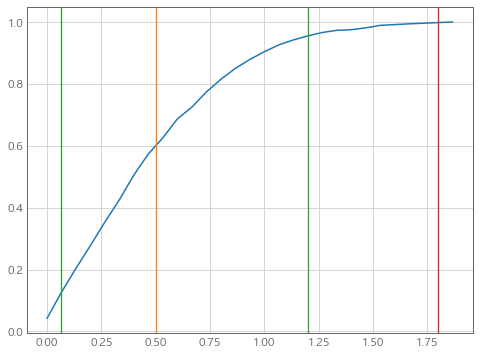

In [59]:
# Plot for null

poisson_rv_null = dsa.DiscreteRv(poisson_results[1])

fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(poisson_rv_null.xk, poisson_rv_null.cdf(poisson_rv_null.xk))
ax.axvline(poisson_rv_null.mean(), color='C1', lw=1.3) # mean, orange line
ax.axvline(poisson_rv_null.ppf(.05), color='C2', lw=1.3) # CI lower, green line
ax.axvline(poisson_rv_null.ppf(.95), color='C2', lw=1.3) # CI upper, green line
ax.axvline(poisson_results[0], color='C3', lw=1.3) # p-value (if comparing with zero), red line

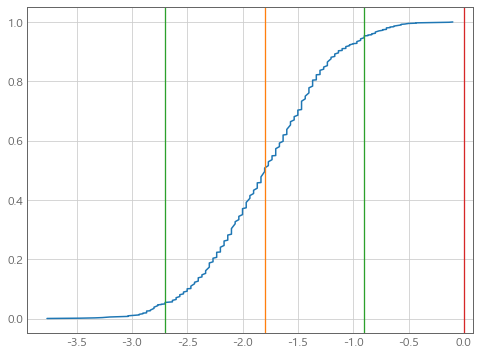

In [60]:
# Plot for alternative

poisson_rv_alt = dsa.DiscreteRv(poisson_results_Ha[1])

fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(poisson_rv_alt.xk, poisson_rv_alt.cdf(poisson_rv_alt.xk))
ax.axvline(poisson_rv_alt.mean(), color='C1', lw=1.3) # mean, orange line
ax.axvline(poisson_rv_alt.ppf(.05), color='C2', lw=1.3) # CI lower, green line
ax.axvline(poisson_rv_alt.ppf(.95), color='C2', lw=1.3) # CI upper, green line
ax.axvline(0, color='C3', lw=1.3) # p-value (if comparing with zero), red line

In [61]:
max(poisson_results_Ha[1])

-0.09999999999999964

### Power calculation function

In [62]:
data = firsts.prglngth.values, others.prglngth.values

In [63]:
def FalseNegRate(data, num_runs=100):
    """Computes the chance of a false negative based on resampling.

    data: pair of sequences
    num_runs: how many experiments to simulate

    returns: float false negative rate
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [64]:
# Need to change left and right alternatives to be smaller and larger like power means below
# I think perhaps the one-sided alternatives are not working because this is based on the null hypothesis case
# Try changing to the Ha alternative hypothesis methods for resampling and try again
# Probably have to make a new function, keep this one in case it doesn't work
# This is the old function that uses the null hypothesis
# It didn't work well because smaller and larger were opposite to how statmodels works

def PowerDiffMeans_old(a, b, alpha = 0.05, alternative = 'two-sided', num_runs=100):
    a = np.array(a)
    b = np.array(b)
    count = 0
    
    for i in range(num_runs):
        sample1 = np.random.choice(a, size=len(a), replace=True)
        sample2 = np.random.choice(b, size=len(b), replace=True)
            
        pooled_data = np.hstack((sample1, sample2))
        sample1_size=len(sample1)
            
        diff_means = abs(sample1.mean() - sample2.mean())
        
        diff_mean_results = []

        if alternative == 'two-sided':
            for j in range(100):
                np.random.shuffle(pooled_data)
                group1 = pooled_data[:sample1_size]
                group2 = pooled_data[sample1_size:]
                # Uses abs of difference between group means to make it a two-sided test
                result = abs(group1.mean() - group2.mean())
                diff_mean_results.append(result)
                  
            rv = dsa.DiscreteRv(diff_mean_results)
            
            p_value = 1 - rv.cdf(diff_means)
            if p_value < alpha:
                count += 1
        
        else:
            for j in range(100):
                np.random.shuffle(pooled_data)
                group1 = pooled_data[:sample1_size]
                group2 = pooled_data[sample1_size:]
                result = group1.mean() - group2.mean()
                diff_mean_results.append(result)
            
            rv = dsa.DiscreteRv(diff_mean_results)
            
            if alternative == 'smaller':
                p_value_right = 1 - rv.cdf(diff_means)
                if p_value_right < alpha:
                    count += 1
            
            elif alternative == 'larger':
                p_value_left = rv.cdf(diff_means)
                if p_value_left < alpha:
                    count += 1
            
            else:
                raise ValueError("alternative has to be 'two-sided', 'smaller', or 'larger'")
    
    return count / num_runs

In [65]:
# This function is built using the alternative hypothesis
# It matches with the smaller and larger alternatives of statsmodels

def PowerDiffMeans(a, b, test_diff_means, alpha = 0.05, alternative = 'two-sided', num_runs=100):
    a = np.array(a)
    b = np.array(b)
    
    # Set counter for significant p-values to zero
    count = 0
    
    # Run resampling of the arrays separately (not pooled) to simulate the alternative hypothesis of a difference existing
    for i in range(num_runs):
        sample1 = np.random.choice(a, size=len(a), replace=True)
        sample2 = np.random.choice(b, size=len(b), replace=True)
        
        diff_mean_results = []
        
        # Build a sampling distribution for the run
        for j in range(100):
            group1 = np.random.choice(sample1, size=len(sample1), replace=True)
            group2 = np.random.choice(sample2, size=len(sample2), replace=True)
            result = group1.mean() - group2.mean()
            diff_mean_results.append(result)
        
        # Create an rv of the results and calculate left and right side p-values
        rv = dsa.DiscreteRv(diff_mean_results)
        p_value_right = 1 - rv.cdf(test_diff_means)
        p_value_left = rv.cdf(test_diff_means)        

        # Case of a two-sided test
        if alternative == 'two-sided':
            if (p_value_right < alpha/2) or (p_value_left < alpha/2):
                count += 1
        
        # Case of testing for an effect that is smaller than the test difference of means
        elif alternative == 'smaller': 
            if p_value_right < alpha:
                count += 1
        
        # Case of testing for an effect that is larger than the test difference of means
        elif alternative == 'larger': 
            if p_value_left < alpha:
                count += 1
        
        else:
            raise ValueError("alternative has to be 'two-sided', 'smaller', or 'larger'")
    
    return count / num_runs

In [66]:
PowerDiffMeans(firsts.prglngth.values, others.prglngth.values, 0, alternative='larger')

0.38

In [67]:
firsts.prglngth.mean() - others.prglngth.mean()

0.07803726677754952

In [68]:
# I think it's working now, but not for one-sided cases
# Old function
# Result: 0.31699999999999995
PowerDiffMeans_old(firsts.prglngth.values, others.prglngth.values, alternative='two-sided')

0.25

In [69]:
# Try this with statsmodels
effect_size = dsa.CohenEffectSize(firsts.prglngth.values, others.prglngth.values)
# effect_size = dsa.CohenEffectSize(others.prglngth.values, firsts.prglngth.values)
nobs1 = len(firsts.prglngth.values)
alpha = 0.05
ratio = len(others.prglngth.values)/ len(firsts.prglngth.values)
# ratio = len(firsts.prglngth.values)/ len(others.prglngth.values)
power_obj = sms.TTestIndPower()
power_obj.solve_power(effect_size=effect_size, nobs1=nobs1, alpha=alpha, ratio=ratio, alternative='larger')

0.3956628152889268

In [70]:
# Make a mean power function
# I think this is working now, getting similar results to statsmodels function (see below)
# One issue though is that I am passing a test mean to the function while statsmodels does not
# Perhaps the effect size of the statsmodels function does something similar to my use of a test stat
# Check how this works in the two sample difference of means case
# Decided not to implement weight option
# Add one-sided alternatives? need these alternatives in diff means one too?
# Do I need to switch my 'larger', 'smaller' positions in the code?
# Right now in need to use the opposite one in statsmodels to get similar power values
# No, these should be opposite because I am looking at the larger and smaller tails of the alternative, not the null
# Changed alternatives to 'right' and 'left' to be more intuitive for my calcualtion
# Changing my mind again on this. I think I should use smaller and larger,
# but in the sense of testing that an effect is smaller or larger.
# I think I can remove the estimates less than test part of the code: did this
# TO-DO: Add comments to code and add one-sided alternatives to diff means power function too

def PowerMean(data, test_mean, alpha=0.05, alternative='two-sided', num_runs=100):
    a = np.array(data)
    
    # Set counter for significant p-values to zero
    count = 0
        
    # Run resampling of the array to simulate the alternative hypothesis of an existing difference from the test mean
    for i in range(num_runs):
        run_data = np.random.choice(a, size=len(a), replace=True)
            
        # Build a sampling distribution for the run
        mean_estimates = [np.random.choice(run_data, size=len(run_data), replace=True).mean() for _ in range(100)]
            
        # Create an rv of the results and calculate left and right side p-values
        rv = dsa.DiscreteRv(mean_estimates)
        p_value_right = 1 - rv.cdf(test_mean)
        p_value_left = rv.cdf(test_mean)
        
        # Case of a two-sided test
        if alternative == 'two-sided':
            if (p_value_right < alpha/2) or (p_value_left < alpha/2):
                count += 1
        
        # Case of testing for an effect that is smaller than the test mean
        elif alternative == 'smaller': 
            if p_value_right < alpha:
                count += 1
        
        # Case of testing for an effect that is larger than the test mean
        elif alternative == 'larger': 
            if p_value_left < alpha:
                count += 1
        
        else:
            raise ValueError("alternative has to be 'two-sided', 'smaller', or 'larger'")
            
    return count / num_runs
    
    # Decided not to add weights option at this point, could come back and do that later
    
#     else:    # In case of weights use a DataFrame
#         df = pd.DataFrame({'data':data,'wgt':weights})
#         count = 0
        
#         for i in range(num_runs):
#             print("run", i)
#             run_data = df.sample(n=len(df), replace=True)
            
#             mean_estimates = [df.sample(n=len(df), replace=True, weights=df.wgt).data.mean() for _ in range(100)]
#             print("mean_estimate_mean", np.array(mean_estimates).mean())
            
#             rv = dsa.DiscreteRv(mean_estimates)
            
#             p_value_right = 1 - rv.cdf(test_mean)
#             print("p-value_right", p_value_right)
#             p_value_left = rv.cdf(test_mean)
#             print("p-value_left", p_value_left)
#             if (np.array(mean_estimates).mean() < test_mean) and (p_value_right > alpha/2):
#                 count += 1
#                 print("count(right)",count)
#             elif (np.array(mean_estimates).mean() >= test_mean) and (p_value_left > alpha/2):
#                 count += 1
#                 print("count(left)",count)

In [71]:
mean_data = np.random.randint(-8,11,size=100)
# mean_weights = np.random.randint(1,8,size=100)
# mean_weights = mean_weights/sum(mean_weights)

In [72]:
mean_series = pd.Series(mean_data)
mean_series.mean()

0.92

In [73]:
PowerMean(data=mean_series.values, test_mean=0, alternative='two-sided')

0.39

In [74]:
# Try with statsmodels
effect_size = mean_series.mean()/mean_series.std()
nobs = len(mean_series)
alpha = 0.05
sms.tt_solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha, alternative='two-sided')

0.3515150853459335

In [75]:
# Try with statsmodels for weighted data
# Don't think this is working, doesn't seem to be equivalent to what I'm doing in the function
# mean_data_weighted = mean_series.values * mean_weights
# effect_size = mean_data_weighted.mean()/mean_data_weighted.std()
# nobs = len(mean_data_weighted)
# alpha = 0.05
# sms.tt_solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha, alternative='two-sided')

In [76]:
# Make a correlation power function

In [93]:
def PowerCorr(data, test_mean, alpha=0.05, alternative='two-sided', num_runs=100):
    x, y = data
    df = pd.DataFrame({'x':x, 'y':y})
    
    
    # Set counter for significant p-values to zero
    count = 0
        
    # Run resampling of the array to simulate the alternative hypothesis of an existing difference from the test mean
    for i in range(num_runs):
       # Create run data
        run_data = df.sample(n=len(df), replace=True)
        
        corrs=[]
        
        # Build rv     
        for _ in range(100):
            sample = run_data.sample(n=len(run_data), replace=True)
            r = stats.pearsonr(sample.x, sample.y)[0]
            corrs.append(r)
            
        # Create an rv of the results and calculate left and right side p-values
        rv = dsa.DiscreteRv(corrs)
        p_value_right = 1 - rv.cdf(test_mean)
        p_value_left = rv.cdf(test_mean)
        
        # Case of a two-sided test
        if alternative == 'two-sided':
            if (p_value_right < alpha/2) or (p_value_left < alpha/2):
                count += 1
        
        # Case of testing for an effect that is smaller than the test mean
        elif alternative == 'smaller': 
            if p_value_right < alpha:
                count += 1
        
        # Case of testing for an effect that is larger than the test mean
        elif alternative == 'larger': 
            if p_value_left < alpha:
                count += 1
        
        else:
            raise ValueError("alternative has to be 'two-sided', 'smaller', or 'larger'")
            
    return count / num_runs

In [94]:
a = np.random.randint(1,20,50)
a

array([12,  7,  2, 12, 11,  5, 15,  5,  6, 12,  5, 15, 10,  2,  8,  2,  5,
       16, 16,  2, 17,  7, 11, 13, 13, 13, 17,  4,  9, 15, 13,  5,  5, 19,
        3,  4, 11, 16,  4, 14,  7, 12, 14,  9,  8,  4,  2,  8,  8,  8])

In [95]:
b = np.random.randint(1,20,50)
b

array([13,  3,  8, 18, 12,  8, 14, 19,  5,  2, 10, 17,  6, 12,  3,  2, 18,
        6, 11,  7, 12, 18, 16, 13, 13, 14, 19,  2, 14, 17,  3,  5, 14,  2,
       10, 14,  9, 11,  2,  5, 11, 18,  3,  4, 18,  1, 11,  4, 18,  3])

In [104]:
data2 = a,b
PowerCorr(data2, 0, alternative='two-sided')

0.23

In [105]:
# Test corr H0 vs corr Ha again using above data

In [109]:
result0 = dsa.ResampleDiffMeans_H0(a,b)

In [110]:
resulta = dsa.ResampleDiffMeans_Ha(a,b)

In [111]:
dsa.SummarizeEstimates(result0[1])

(0.8609199999999999,
 0.6378419503293901,
 (0.019999999999999574, 2.3000000000000007))

In [112]:
dsa.SummarizeEstimates(resulta[1])

(-0.7205400000000001,
 1.0768279845917825,
 (-2.8200000000000003, 1.4400000000000013))

In [114]:
dsa.PvalueFromEstimates(result0[1], result0[0])

0.4919999999999999

In [115]:
dsa.PvalueFromEstimates(resulta[1], 0)

0.24099999999999944

In [ ]:
# There is quite a difference between the above, perhaps there is a significant difference between the two methods

### ANOVA

### Just a duplicates checking function

In [78]:
def duplicates(l):
    dup = False
    for i in l:
        dup_counter=0
        for j in l:
            if i==j:
                dup_counter +=1
                if dup_counter > 1:
                    dup = True
                    return dup
    return dup                    

In [79]:
l = [1,3,8,7,3,9]

In [80]:
duplicates(l)

True

### A selection sort function

In [81]:
def SelectionSort(l):
    lower_limit_index = 0
    pointer = lower_limit_index
    while lower_limit_index < len(l)-1:
        for i in range(lower_limit_index, len(l)):
            if l[i] < l[pointer]:
                pointer=i
        l[lower_limit_index], l[pointer]=l[pointer],l[lower_limit_index]
        lower_limit_index += 1
        pointer=lower_limit_index
    return l

In [82]:
l = [3,7,9,4,2,8,5,1]

In [83]:
SelectionSort(l)

[1, 2, 3, 4, 5, 7, 8, 9]

In [84]:
list(range(3, len(l)))

[3, 4, 5, 6, 7]

### An insertion sort function

In [85]:
def InsertionSort(a):
    for i in range(1, len(a)):
        temp_value = a[i]
        for j in range(i-1, -1,-1):
            if a[j] > temp_value:
                a[j+1] = a[j]
                if j == 0:
                    a[0] = temp_value
                    break
            if a[j] < temp_value:
                a[j+1] = temp_value
                break
    return a

In [86]:
insert_a = [3,7,9,4,2,8,1]

In [87]:
InsertionSort(insert_a)

[1, 2, 3, 4, 7, 8, 9]

In [88]:
list(range(1-1,-1,-1))

[0]

In [89]:
insert_a[1:]

[2, 3, 4, 7, 8, 9]